In [2]:
import numpy as np
import os
import sys
import pickle
import pandas as pd
from multiprocessing import Pool
%matplotlib inline
import matplotlib.pyplot as plt

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from keras.constraints import maxnorm
from keras.engine import Input
from keras.engine import Model
from keras.layers import Dropout, Dense, Bidirectional, LSTM, \
    Embedding, GaussianNoise, Activation, Flatten, \
    RepeatVector, MaxoutDense, GlobalMaxPooling1D, \
    Convolution1D, MaxPooling1D, concatenate, Conv1D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from kutilities.layers import AttentionWithContext, Attention, MeanOverTime
from kutilities.helpers.data_preparation import print_dataset_statistics, \
labels_to_categories, categories_to_onehot
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import recall_score
from kutilities.callbacks import MetricsCallback, PlottingCallback
from kutilities.helpers.data_preparation import get_labels_to_categories_map, \
get_class_weights2, onehot_to_categories
from keras.callbacks import ModelCheckpoint
import scipy.stats
import keras
from keras.utils import np_utils

Using TensorFlow backend.
/home/arthur/anaconda3/envs/dlnlp/lib/python3.6/site-packages/kutilities/callbacks.py:6: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('TkAgg')


In [3]:
embedding_dim = 300
if os.path.exists('../data/datastories.twitter.300d.pickle'):
    with open('../data/datastories.twitter.300d.pickle', 'rb') as f:
        wv_data = pickle.load(f)

wv_data["<unk>"] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
wv_data["<pad>"] = np.zeros(embedding_dim)
        
embeddings = np.zeros((len(wv_data), embedding_dim), dtype=np.float32)
wv_id = dict()
for i, (w, v) in enumerate(wv_data.items()):
    embeddings[i] = v.copy()
    wv_id[w] = i
    

In [4]:
text_processor = TextPreProcessor(
    backoff=['url', 'email', 'percent', 'money', 'phone', 'user',
             'time', 'url', 'date', 'number'],
    include_tags={"hashtag", "allcaps", "elongated", "repeated",
                  'emphasis', 'censored'},
    fix_html=True,
    segmenter="twitter",
    corrector="twitter",
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=True).tokenize, dicts=[emoticons]
)

text_processor.pre_process_doc('the quick brown fox jumped over the lazy dog')

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']

In [5]:
Xtrain = []
Ytrain = []

df = pd.read_csv('../data/emotion.data', sep=',')
Xtrain += list(df.text.values)
#Ytrain += list(map(lambda x: {'negative': 0, 'positive': 2, 'neutral': 1}[x], df[1].values))
#print(df.emotions.values.unique)
#print(df.head())
print(df.emotions.unique())
df.head()

['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [6]:
Xtrain = []
Ytrain = []

df = pd.read_csv('../data/train.txt', sep='\t', index_col=0)
Xtrain = np.array(df[['turn1', 'turn2', 'turn3']])

Ytrain = list(map(lambda x: {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}[x], df.label.values))
Ytrain = np_utils.to_categorical(Ytrain)

print(Xtrain.shape, Ytrain.shape)
print(Xtrain[1:3])
print(df.label.unique())


df.head()

(30160, 3) (30160, 4)
[['When did I?' 'saw many times i think -_-' 'No. I never saw you']
 ['By' 'by Google Chrome' 'Where you live']]
['others' 'angry' 'sad' 'happy']


,turn1,turn2,turn3,label
id,,,,
0,Don't worry I'm girl,hmm how do I know if you are,What's ur name?,others
1,When did I?,saw many times i think -_-,No. I never saw you,angry
2,By,by Google Chrome,Where you live,others
3,U r ridiculous,I might be ridiculous but I am telling the truth.,U little disgusting whore,angry
4,Just for time pass,wt do u do 4 a living then,Maybe,others


In [7]:
def proces(s):
    return list(map(lambda x: text_processor.pre_process_doc(x), s))

with Pool(processes=4) as pool:
    Xtrain = np.array(list(pool.map(proces, Xtrain)))
    max_len_0 = len(max(Xtrain[:, 0], key=len))
    max_len_1 = len(max(Xtrain[:, 1], key=len))
    max_len_2 = len(max(Xtrain[:, 2], key=len))
    
max_len = [max_len_0, max_len_1, max_len_2]
print(max_len)

[73, 34, 145]


In [15]:
from collections import defaultdict
h = [defaultdict(int), defaultdict(int), defaultdict(int)]

for v in Xtrain:
    h[0][len(v[0])] += 1
    h[1][len(v[1])] += 1
    h[2][len(v[2])] += 1
    #print(v)
hl = []
for i in range(3):
    hl.append([h[i][x] for x in range(max_len[i] + 1)])


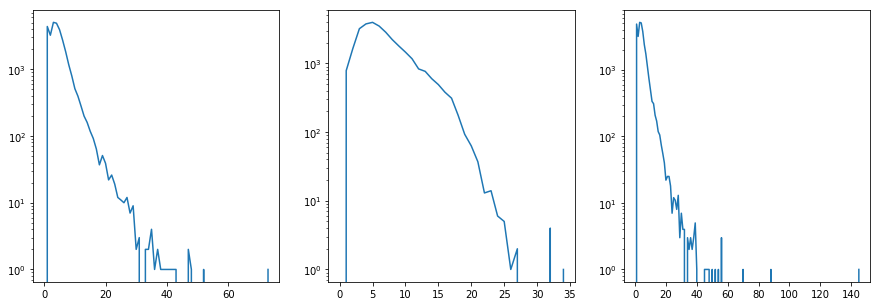

In [35]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(range(max_len[0] + 1), hl[0])
plt.yscale('log')

plt.subplot(1,3,2)
plt.plot(range(max_len[1] + 1), hl[1])
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(range(max_len[2] + 1), hl[2])
plt.yscale('log')

max_len = [40, 34, 40]

In [36]:
for i in range(len(Xtrain)):
    for j in range(len(Xtrain[i])):
        for k in range(len(Xtrain[i][j])):
            if Xtrain[i][j][k] not in wv_data.keys():
                Xtrain[i][j][k] = wv_id['<unk>']
            else:
                Xtrain[i][j][k] = wv_id[Xtrain[i][j][k]]
        Xtrain[i][j] = Xtrain[i][j][:max_len[j]]
        Xtrain[i][j] += [wv_id['<pad>']] * (max_len[j] - len(Xtrain[i][j]))
Xtrain = np.array(Xtrain)
print(Xtrain.shape)

(30160, 3)
[35, 23, 1149, 9, 38, 184, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Deep Learning

In [95]:
tmp_train = np.asarray(Ytrain).argmax(axis=-1)
unique, counts = np.unique(tmp_train, return_counts=True)
dict(zip(unique, counts))

{0: 14948, 1: 5506, 2: 5463, 3: 4243}

In [37]:
def get_RNN(unit=LSTM, cells=64, bi=False, return_sequences=True, dropout_U=0.,
            consume_less='cpu', l2_reg=0):
    rnn = unit(cells, return_sequences=return_sequences,
               consume_less=consume_less, dropout_U=dropout_U,
               W_regularizer=l2(l2_reg))
    if bi:
        return Bidirectional(rnn)
    else:
        return rnn

In [38]:
#dic = {'negative': 0, 'neutral': 1, 'positive': 2}
dic = {'others': 0, 'angry': 1, 'sad': 2, 'happy': 3}

metrics = {
    "f1_pn": (lambda y_test, y_pred:
              f1_score(y_test, y_pred, average='macro',
                       labels=[dic['happy'],
                               dic['sad'],
                               dic['angry'],
                               dic['others']])),
    "M_recall": (
        lambda y_test, y_pred: recall_score(y_test, y_pred, average='macro')),
    "M_precision": (
        lambda y_test, y_pred: precision_score(y_test, y_pred,
                                               average='macro')),
    "pearson": (
        lambda y_test, y_pred: scipy.stats.pearsonr(y_test, y_pred)[0])
}

#classes = ['positive', 'negative', 'neutral']
#class_to_cat_mapping = get_labels_to_categories_map(classes)
#cat_to_class_mapping = {v: k for k, v in
#                        get_labels_to_categories_map(classes).items()}

_datasets = {}
_datasets["1-train"] = (Xtrain, Ytrain)
_datasets["2-val"] = (Xtest, Ytest)

metrics_callback = MetricsCallback(datasets=_datasets, metrics=metrics)
plotting = PlottingCallback(grid_ranges=(0.5, 0.75), height=5,
                            benchmarks={"SE17": 0.681})

_callbacks = []
_callbacks.append(metrics_callback)
#_callbacks.append(plotting)

checkpointer = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.hdf5',
                               monitor='val.macro_recall', mode="max",
                               verbose=1, save_best_only=False)
_callbacks.append(checkpointer)

NameError: name 'Xtest' is not defined